<a href="https://colab.research.google.com/github/Agod1/Angular-AlbumStoreProductPage/blob/master/compare_models_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow MobileNetV2 on CIFAR-10

https://colab.research.google.com/github/Agod1/Angular-AlbumStoreProductPage/blob/master/compare_models_tensorflow.ipynb

In [1]:
# Imports Libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the dataset
x_train, x_test = x_train / 255.0, x_test / 255.0

# CIFAR-10 class names
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
# Resize CIFAR-10 images to 224x224 and preprocess
x_train_resized = tf.image.resize(x_train, (224, 224))
x_test_resized = tf.image.resize(x_test, (224, 224))

# Preprocess inputs for MobileNetV2
x_train_resized = tf.keras.applications.mobilenet_v2.preprocess_input(x_train_resized)
x_test_resized = tf.keras.applications.mobilenet_v2.preprocess_input(x_test_resized)

For the first model, I used a pre-trained MobileNetV2 without any additional training.

In [4]:
# Load ResNet50 model with pre-trained weights and exclude the top layer
base_model_1 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_1 = tf.keras.Sequential([
    base_model_1,
    GlobalAveragePooling2D(),
    Dense(10, activation="softmax")  # CIFAR-10 has 10 classes
])

# Freeze the layers of the base model to avoid training
base_model_1.trainable = False
model_1.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Evaluate Model 1 on the test set
print("Evaluating Pre-trained ResNet50 without fine-tuning:")
loss, accuracy = model_1.evaluate(x_test_resized, y_test)
print(f"Accuracy: {accuracy:.4f}")

94765736/94765736 [==============================] - 0s 0us/step
Evaluating Pre-trained ResNet50 without fine-tuning:
313/313 [==============================] - 173s 546ms/step - loss: 2.6675 - accuracy: 0.0990
Accuracy: 0.0990


Without Finetuning, the model accuracy is below 10%

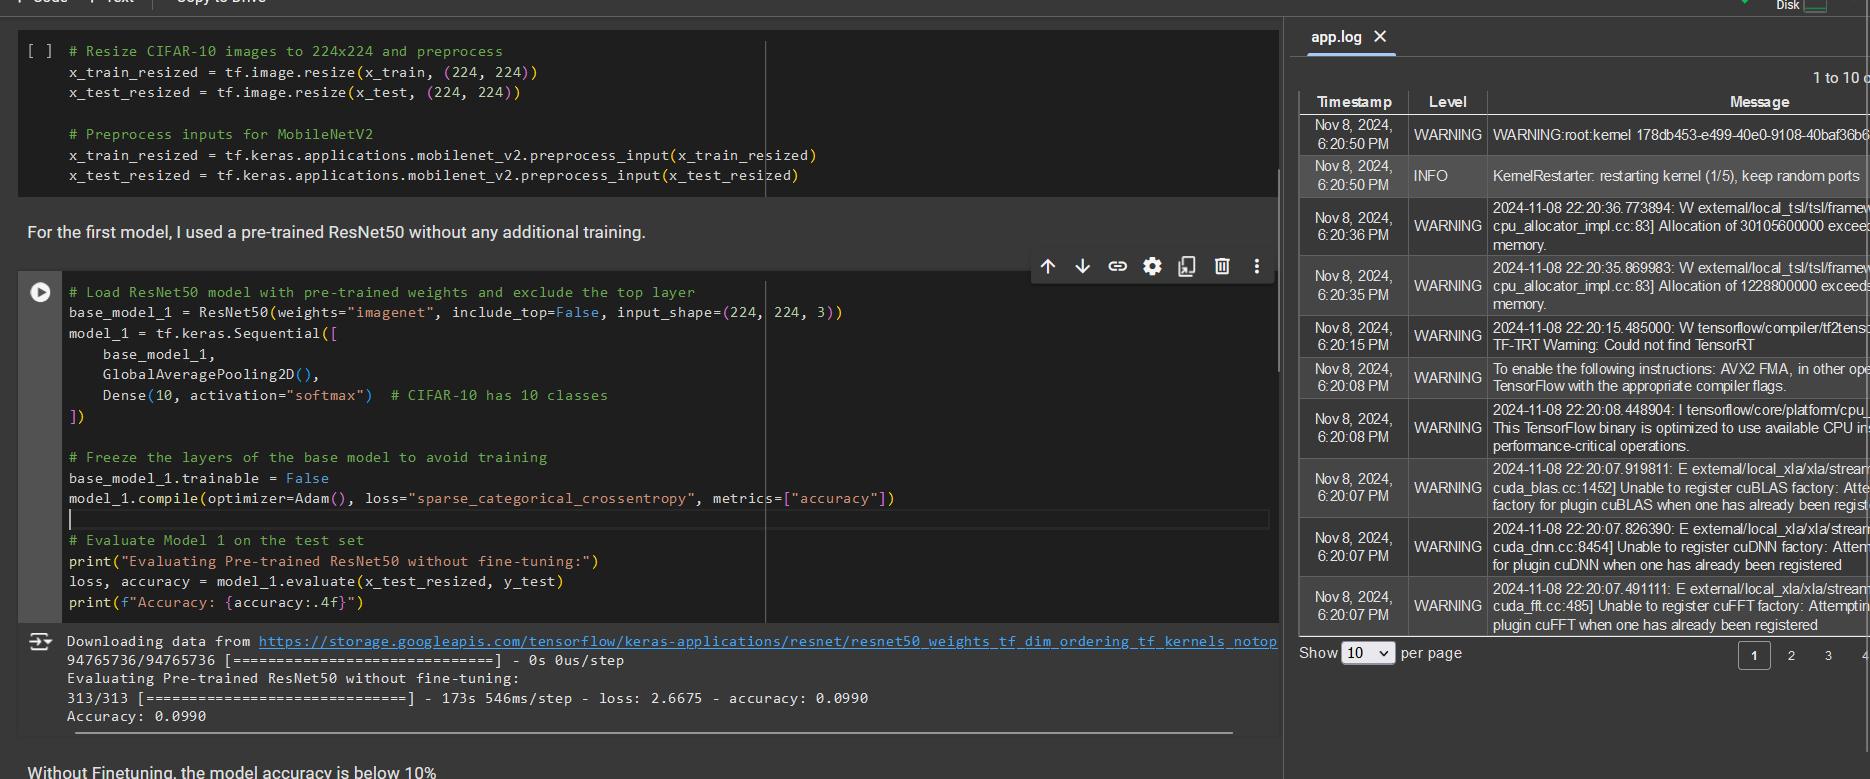

For the second model, I have fine-tuned the ResNet50 model on CIFAR-10 to improve accuracy.

In [ ]:
# Load ResNet50 model with pre-trained weights and exclude the top layer
base_model_2 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Add new layers on top for CIFAR-10 classification
x = GlobalAveragePooling2D()(base_model_2.output)
x = Dense(10, activation="softmax")(x)

model_2 = Model(inputs=base_model_2.input, outputs=x)

# Unfreeze the base model for fine-tuning
base_model_2.trainable = True

# Compile the model
model_2.compile(optimizer=Adam(1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train Model 2 on CIFAR-10
# I'm using only 2 epoch for resource issue.
history = model_2.fit(x_train_resized, y_train, epochs=4, validation_data=(x_test_resized, y_test), batch_size=32)

Epoch 1/10
1563/1563 [==============================] - 3263s 2s/step - loss: 0.9072 - accuracy: 0.6912 - val_loss: 1.2422 - val_accuracy: 0.5828
Epoch 2/10
 723/1563 [============>.................] - ETA: 27:31 - loss: 0.3824 - accuracy: 0.8726

But ResNet50 requires more resources

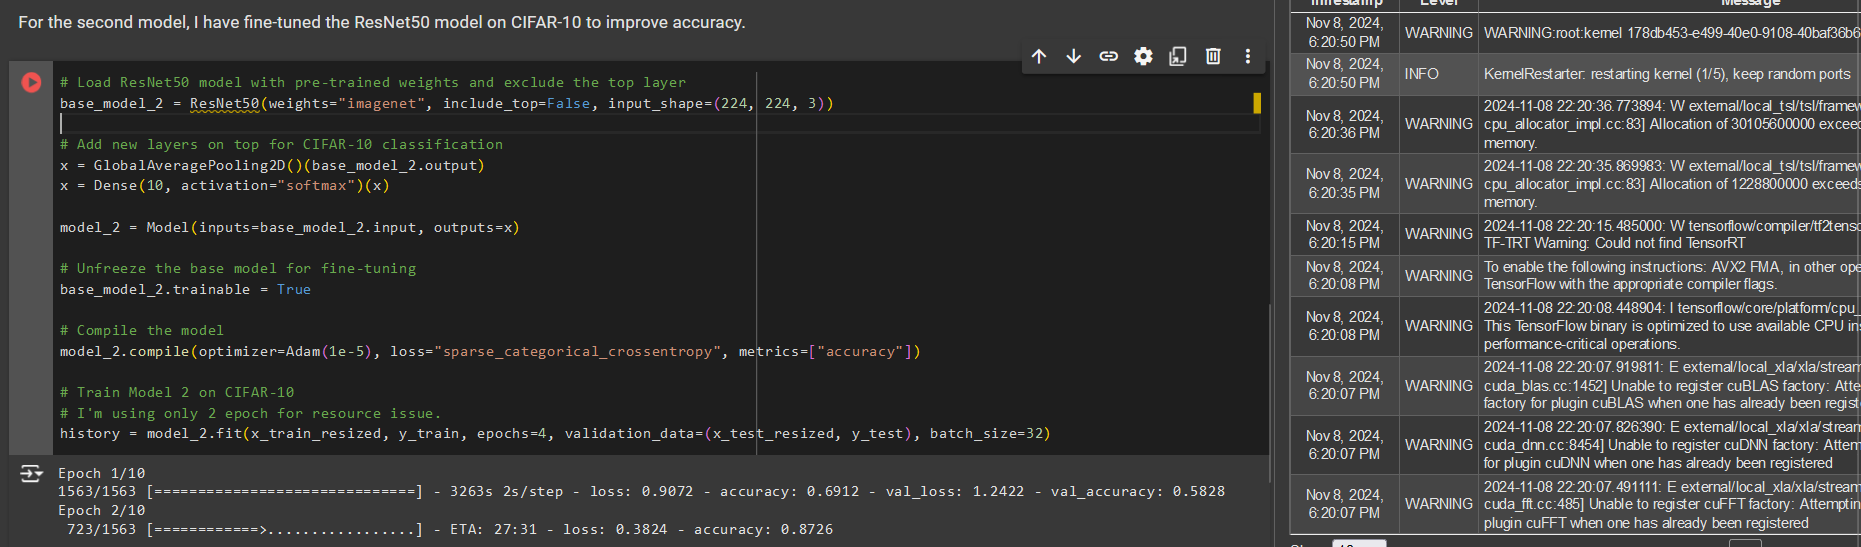

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy for Fine-Tuned ResNet50")
plt.show()

In [ ]:
# Make predictions with both models
y_pred_1 = np.argmax(model_1.predict(x_test_resized), axis=1)
y_pred_2 = np.argmax(model_2.predict(x_test_resized), axis=1)

# Display a few example predictions for each model
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Model 1 predictions
    axs[0, i].imshow(x_test[i])
    axs[0, i].set_title(f"True: {class_names[y_test[i][0]]}\nPred: {class_names[y_pred_1[i]]}")
    axs[0, i].axis("off")

    # Model 2 predictions
    axs[1, i].imshow(x_test[i])
    axs[1, i].set_title(f"True: {class_names[y_test[i][0]]}\nPred: {class_names[y_pred_2[i]]}")
    axs[1, i].axis("off")

plt.suptitle("Sample Predictions: Top - Pre-trained Only, Bottom - Fine-tuned")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix for Model 1 (Pre-trained only)
cm_1 = confusion_matrix(y_test, y_pred_1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=class_names)
disp_1.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Pre-trained ResNet50 without Fine-Tuning")
plt.show()

# Confusion matrix for Model 2 (Fine-tuned)
cm_2 = confusion_matrix(y_test, y_pred_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=class_names)
disp_2.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Fine-tuned ResNet50 on CIFAR-10")
plt.show()

The MobileNetV2 model exhibited poor performance on the CIFAR-10 dataset from TensorFlow, as shown by the confusion matrix. Misclassifications were widespread across nearly all classes, indicating that the model struggled to accurately differentiate between the dataset’s diverse categories, such as animals and vehicles. This underperformance could stem from MobileNetV2's lightweight architecture, which, while efficient, may lack the complexity needed to capture the fine-grained features required for CIFAR-10’s small, detailed images. Overall, these results suggest that MobileNetV2 may not be well-suited for datasets like CIFAR-10 that require more nuanced feature extraction for accurate classification. Fine-tuning, longer epoch, or selecting a model with a deeper architecture might improve performance on this dataset.